# IST 718 - Big Data Analytics Final Project
## **New York City AirBnb Data Set**
###**License**
CC0: Public Domain

##About Dataset

**Context**

Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.

**Content**

This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.

**Acknowledgements**

This public dataset is part of Airbnb, and the original source can be found on this website.

**Inspiration**

What can we learn about different hosts and areas?

What can we learn from predictions? (ex: locations, prices, reviews, etc)

Which hosts are the busiest and why?

Is there any noticeable difference of traffic among different areas and what could be the reason for it?

In [ ]:
! pip install --upgrade pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c02410a8599798d0e757ec578124f4a2b94804e24411554d59b38c2f6b9f4360
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 208MB/s]


In [ ]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Airbnb_Price_Prediction').getOrCreate()
sc = spark.sparkContext

In [ ]:
import pandas as pd
data = pd.read_csv('AB_NYC_2019.csv')
df = spark.createDataFrame(data)

1. Data preprocessing - Handling format, null values, duplication, outliers, and feature engineering

In [ ]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: long (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: long (nullable = true)
 |-- minimum_nights: long (nullable = true)
 |-- number_of_reviews: long (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: long (nullable = true)
 |-- availability_365: long (nullable = true)



1A. Format Changing

In [ ]:
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql.types import DoubleType

df = df.withColumn("last_review", unix_timestamp(col("last_review").cast("date")).cast(DoubleType()))
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: long (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: long (nullable = true)
 |-- minimum_nights: long (nullable = true)
 |-- number_of_reviews: long (nullable = true)
 |-- last_review: double (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: long (nullable = true)
 |-- availability_365: long (nullable = true)



1B. Handling missing values

In [ ]:
import pandas as pd
from pyspark.sql.functions import isnan

missing_values = [(column, df.filter(isnan(col(column)) | (col(column).isNull())).count()) for column in df.columns]
missing_df = pd.DataFrame(missing_values, columns=['Column', 'Missing Values'])
print(missing_df)


                            Column  Missing Values
0                               id               0
1                             name              16
2                          host_id               0
3                        host_name              27
4              neighbourhood_group               0
5                    neighbourhood               0
6                         latitude               0
7                        longitude               0
8                        room_type               0
9                            price               0
10                  minimum_nights               0
11               number_of_reviews               0
12                     last_review           10052
13               reviews_per_month           10052
14  calculated_host_listings_count               0
15                availability_365               0


In [ ]:
from pyspark.ml.feature import Imputer

columns_with_missing_values = ["last_review", "reviews_per_month"]
imputer = Imputer(inputCols=columns_with_missing_values, outputCols=columns_with_missing_values)
df = imputer.fit(df).transform(df)

In [ ]:
columns_to_drop = ["id", "name", "host_name"]
df = df.drop(*columns_to_drop)

In [ ]:
missing_values = [(column, df.filter(isnan(col(column)) | (col(column).isNull())).count()) for column in df.columns]
missing_df = pd.DataFrame(missing_values, columns=['Column', 'Missing Values'])
print(missing_df)

                            Column  Missing Values
0                          host_id               0
1              neighbourhood_group               0
2                    neighbourhood               0
3                         latitude               0
4                        longitude               0
5                        room_type               0
6                            price               0
7                   minimum_nights               0
8                number_of_reviews               0
9                      last_review               0
10               reviews_per_month               0
11  calculated_host_listings_count               0
12                availability_365               0


1C. Checking duplication

In [ ]:
duplicate_counts = df.groupBy(df.columns).count().filter(col("count") > 1).orderBy(col("count").desc())
duplicate_counts.show()

+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-----+
|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|count|
+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-----+
+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-----+



1D. Handling outliers and too small values

In [ ]:
quartiles = df.approxQuantile("price", [0.25, 0.75], 0.01)
iqr = 1.5 * (quartiles[1] - quartiles[0])
lower_bound = quartiles[0] - iqr
upper_bound = quartiles[1] + iqr

outliers = df.filter((col("price") < lower_bound) | (col("price") > upper_bound))
outlier_count = outliers.count()
print(f"Column price has {outlier_count} outliers.")

Column price has 2972 outliers.


In [ ]:
df = df.filter((col("price") >= lower_bound) & (col("price") <= upper_bound))
min_price_threshold = 10
df = df.filter(col("price") >= min_price_threshold)
print("Number of rows after removing outliers:", df.count())

Number of rows after removing outliers: 45912


1E. Summary statistics

In [ ]:
selected_columns = ['price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
summary_stats = df.select([col(column) for column in selected_columns]).describe()
summary_stats.show()

+-------+------------------+------------------+------------------+--------------------+------------------+------------------------------+------------------+
|summary|             price|    minimum_nights| number_of_reviews|         last_review| reviews_per_month|calculated_host_listings_count|  availability_365|
+-------+------------------+------------------+------------------+--------------------+------------------+------------------------------+------------------+
|  count|             45912|             45912|             45912|               45912|             45912|                         45912|             45912|
|   mean|119.99906342568391| 6.937968287158041|23.940189928558983|1.5385232174698176E9|1.3771436292135457|             6.640268339431957|109.37593657431609|
| stddev|  68.1330033042982|19.859504858170194|45.316221444172704|  3.20851732578215E7| 1.516855655074301|            31.011826265107864|130.28436781024064|
|    min|                10|                 1|           

1F. Feature Engineering

In [ ]:
print(df.select('neighbourhood_group').distinct().count())
print(df.select('neighbourhood').distinct().count())
print(df.select('room_type').distinct().count())

5
219
3


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

string_indexer = StringIndexer(inputCols=["room_type", "neighbourhood", "neighbourhood_group"],
                               outputCols=["room_type_numeric", "neighbourhood_numeric", "neighbourhood_group_numeric"])
model = string_indexer.fit(df)
df = model.transform(df)


In [ ]:
ohe = OneHotEncoder(inputCols=["room_type_numeric", "neighbourhood_numeric", "neighbourhood_group_numeric"],
                    outputCols=["room_type_ohe", "neighbourhood_ohe", "neighbourhood_group_ohe"])
df = ohe.fit(df).transform(df)
df.show(5)

+-------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+--------------------+------------------+------------------------------+----------------+-----------------+---------------------+---------------------------+-------------+-----------------+-----------------------+
|host_id|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|         last_review| reviews_per_month|calculated_host_listings_count|availability_365|room_type_numeric|neighbourhood_numeric|neighbourhood_group_numeric|room_type_ohe|neighbourhood_ohe|neighbourhood_group_ohe|
+-------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+--------------------+------------------+------------------------------+----------------+-----------------+---------------------+---------------------------+-------------+-----------------+-----------------------+
|   2787| 

2. Analysis

2A. Converting price to 3 price categories

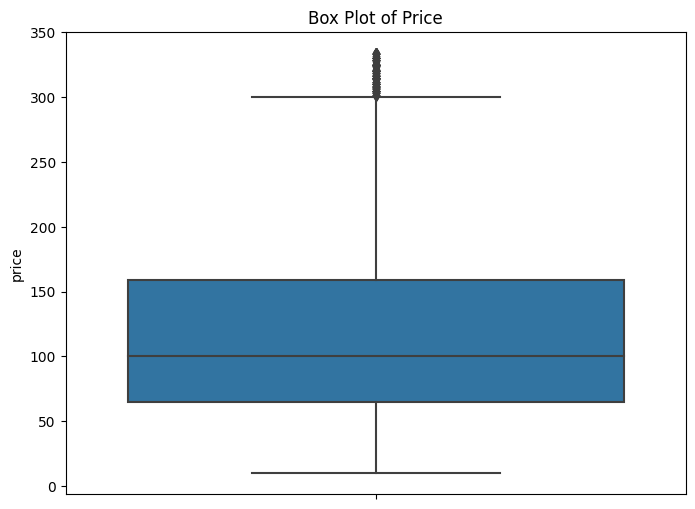

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df.toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(data=pandas_df, y='price')
plt.title('Box Plot of Price')
plt.show()

In [ ]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

splits = [-float('inf'), 60, 160, float('inf')]

bucketizer = Bucketizer(
    inputCol='price',
    outputCol='price_category',
    splits=splits)
df_with_category = bucketizer.transform(df)
df = df_with_category.withColumn(
    'price_category',
    F.when(F.col('price_category') == 0.0, 'Low')
    .when(F.col('price_category') == 1.0, 'Medium')
    .when(F.col('price_category') == 2.0, 'High'))
df.show(3)

+-------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+--------------------+------------------+------------------------------+----------------+-----------------+---------------------+---------------------------+-------------+-----------------+-----------------------+--------------+
|host_id|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|         last_review| reviews_per_month|calculated_host_listings_count|availability_365|room_type_numeric|neighbourhood_numeric|neighbourhood_group_numeric|room_type_ohe|neighbourhood_ohe|neighbourhood_group_ohe|price_category|
+-------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+--------------------+------------------+------------------------------+----------------+-----------------+---------------------+---------------------------+-------------+-----------------+-----

In [ ]:
df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'price_category').show(5)


+-------------------+-------------+---------------+-----+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|price_category|
+-------------------+-------------+---------------+-----+--------------+
|           Brooklyn|   Kensington|   Private room|  149|        Medium|
|          Manhattan|      Midtown|Entire home/apt|  225|          High|
|          Manhattan|       Harlem|   Private room|  150|        Medium|
|           Brooklyn| Clinton Hill|Entire home/apt|   89|        Medium|
|          Manhattan|  East Harlem|Entire home/apt|   80|        Medium|
+-------------------+-------------+---------------+-----+--------------+
only showing top 5 rows



2B. Analyzing price and predictor variables

Correlation between Price and the variables

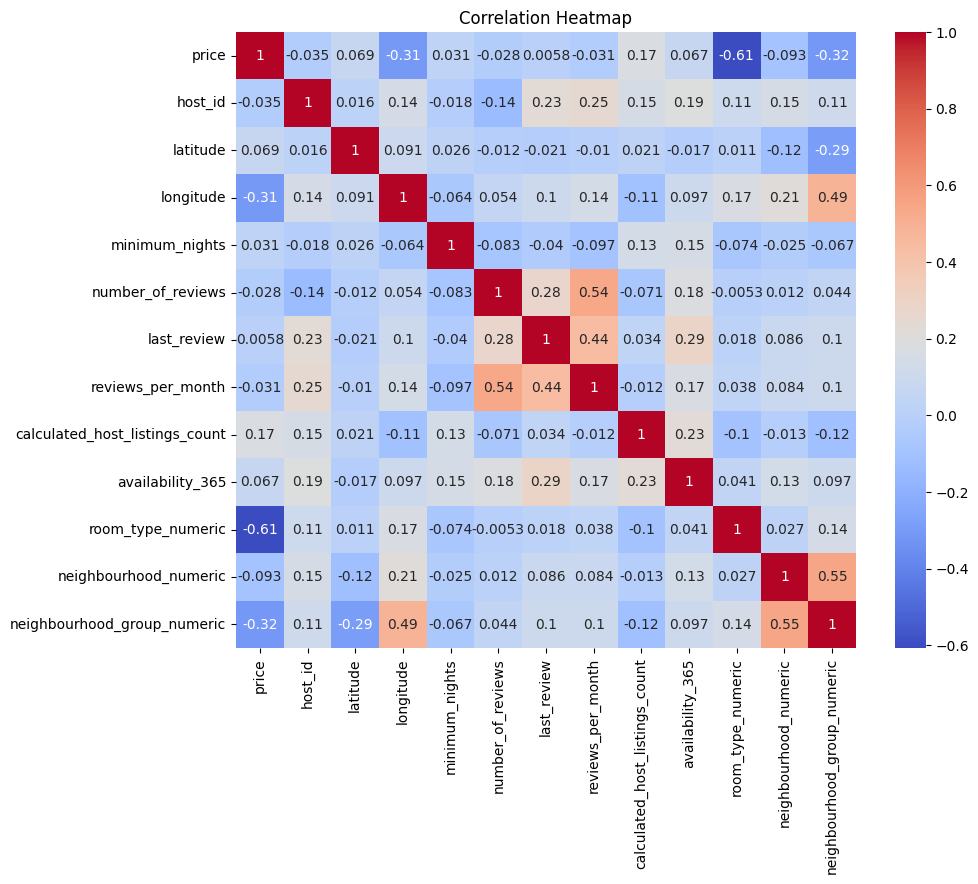

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = pandas_df[['price', 'host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month',
               'calculated_host_listings_count', 'availability_365', "room_type_numeric", "neighbourhood_numeric", "neighbourhood_group_numeric"]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Neighborhood groups by price category

In [ ]:
df.select('neighbourhood_group').distinct().show()

+-------------------+
|neighbourhood_group|
+-------------------+
|             Queens|
|           Brooklyn|
|      Staten Island|
|          Manhattan|
|              Bronx|
+-------------------+



In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.toPandas()
pandas_df['hover_info'] = pandas_df['neighbourhood_group'] + ' - ' + pandas_df['price_category']
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="hover_info",
    mapbox_style="open-street-map",
    zoom=10)
fig.write_html("interactive_neighborhood_groups.html")
fig.show()

Queens by price category

In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.filter(df['neighbourhood_group'] == 'Queens').toPandas()
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="neighbourhood",
    mapbox_style="open-street-map",
    zoom=10)
fig.show()

Brooklyn by price catergory

In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.filter(df['neighbourhood_group'] == 'Brooklyn').toPandas()
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="neighbourhood",
    mapbox_style="open-street-map",
    zoom=10)
fig.show()

Staten Island by price catergory

In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.filter(df['neighbourhood_group'] == 'Staten Island').toPandas()
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="neighbourhood",
    mapbox_style="open-street-map",
    zoom=10)
fig.show()

Manhattan by price category

In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.filter(df['neighbourhood_group'] == 'Manhattan').toPandas()
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="neighbourhood",
    mapbox_style="open-street-map",
    zoom=10)
fig.show()

Bronx by price category

In [ ]:
import plotly.express as px
import pandas as pd

pandas_df = df.filter(df['neighbourhood_group'] == 'Bronx').toPandas()
fig = px.scatter_mapbox(
    pandas_df,
    lat="latitude",
    lon="longitude",
    color="price_category",
    hover_name="neighbourhood",
    mapbox_style="open-street-map",
    zoom=10)
fig.show()

Room type by category

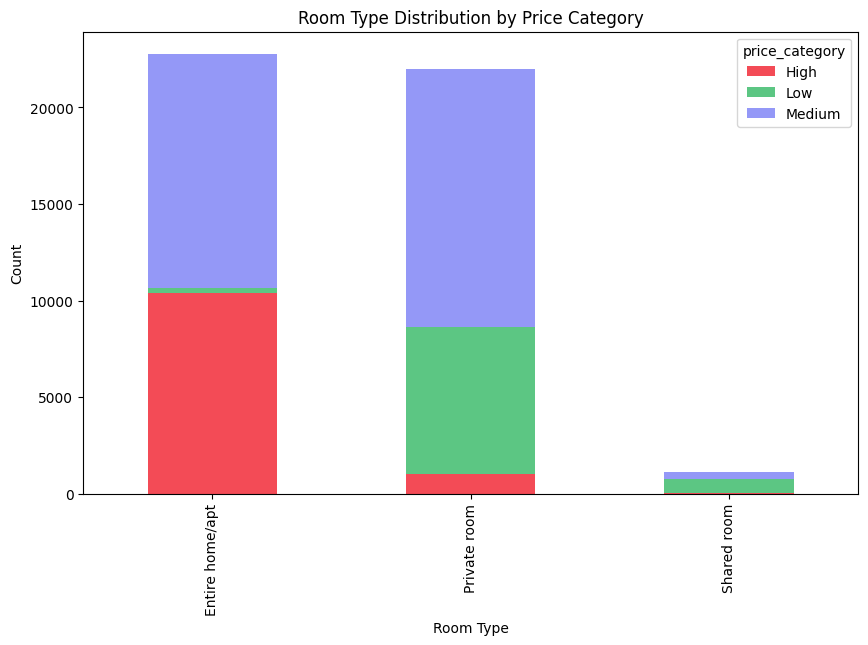

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pivot_df = pandas_df.pivot_table(index='room_type', columns='price_category', aggfunc='size', fill_value=0)
colors = {'Medium': '#797EF6', 'High': '#f01e2c', 'Low': '#33b864'}
pivot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_df.columns], alpha=0.8, figsize=(10, 6))

plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Room Type Distribution by Price Category')
plt.show()

Average Price by Room Type

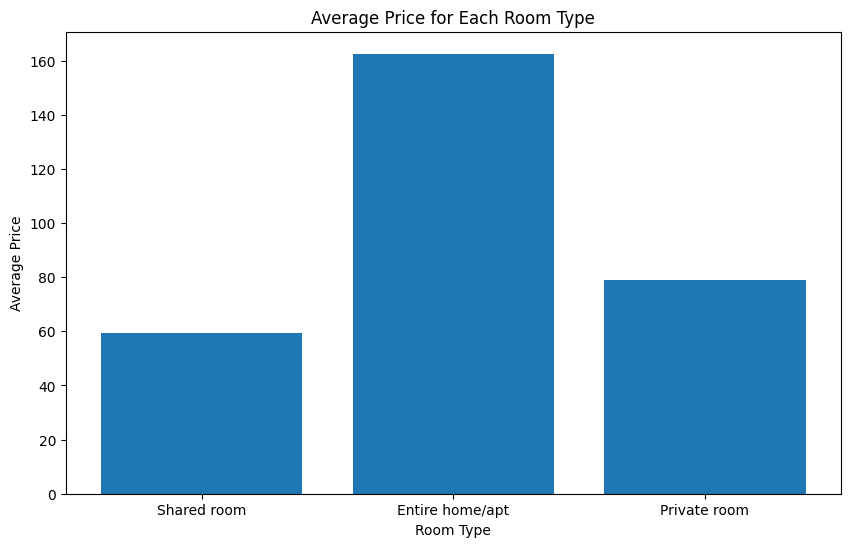

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
average_prices = df.groupBy('room_type').agg(F.avg('price').alias('average_price'))
average_prices_pandas = average_prices.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(average_prices_pandas['room_type'], average_prices_pandas['average_price'])
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Average Price for Each Room Type')
plt.show()


Average Price by Neighbourhood Group

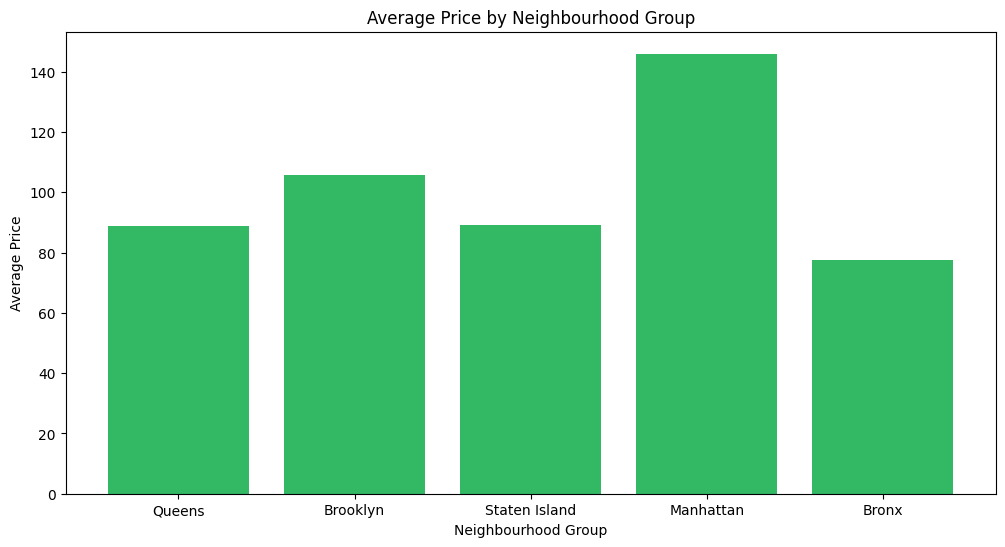

In [ ]:
import matplotlib.pyplot as plt

average_prices_by_neighbourhood = df.groupBy('neighbourhood_group').agg(F.avg('price').alias('average_price'))
average_prices_neighbourhood_pandas = average_prices_by_neighbourhood.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(average_prices_neighbourhood_pandas['neighbourhood_group'], average_prices_neighbourhood_pandas['average_price'], color='#33b864')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')
plt.title('Average Price by Neighbourhood Group')
plt.show()


Average Price by Neighbourhood Group and Room Type

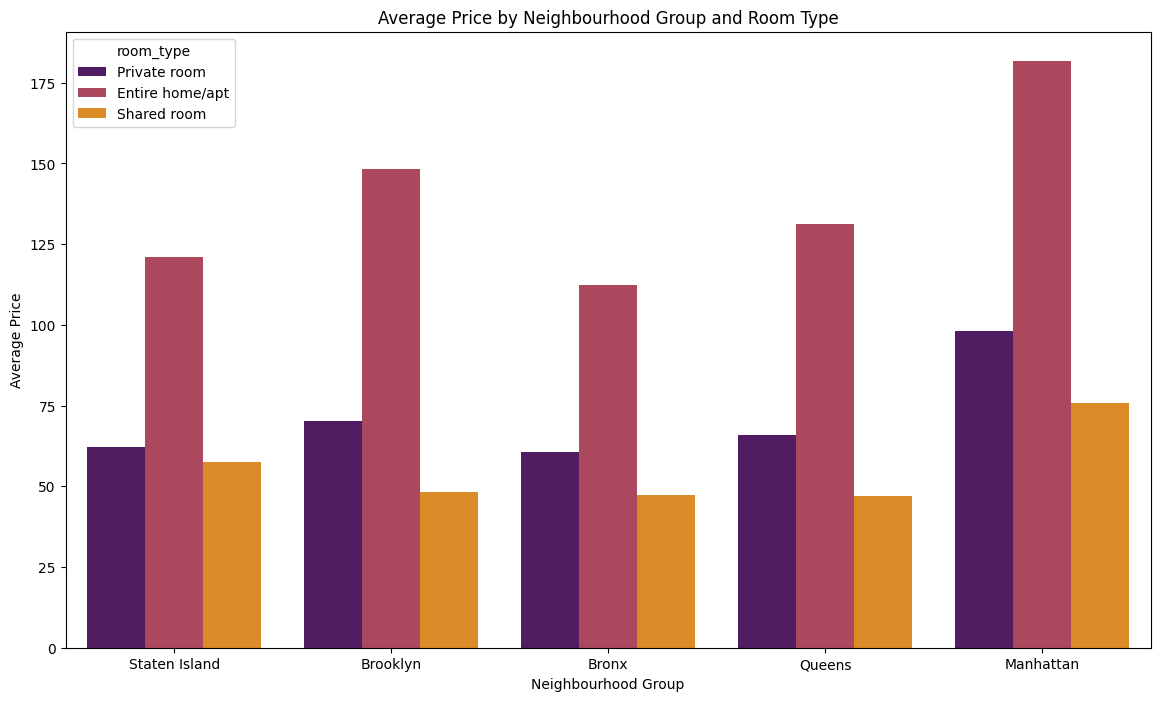

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

grouped_df = df.groupBy('neighbourhood_group', 'room_type')
average_prices_by_neighbourhood_room_type = grouped_df.agg(
    F.mean('price').alias('average_price')
)
average_prices_neighbourhood_room_type_pandas = average_prices_by_neighbourhood_room_type.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(
    x='neighbourhood_group',
    y='average_price',
    hue='room_type',
    data=average_prices_neighbourhood_room_type_pandas,
    palette='inferno'
)

plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')
plt.title('Average Price by Neighbourhood Group and Room Type')
plt.show()


Geographical Distribution of Listings

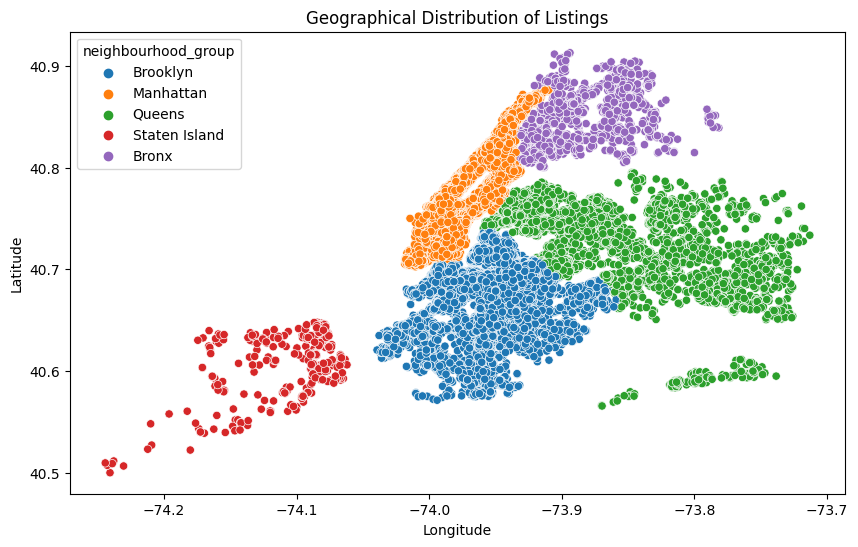

In [ ]:
# Geographical Distribution of Listings
pandas_df = df.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='longitude', y='latitude', hue='neighbourhood_group')
plt.title('Geographical Distribution of Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Correlation between Price and Number of Reviews

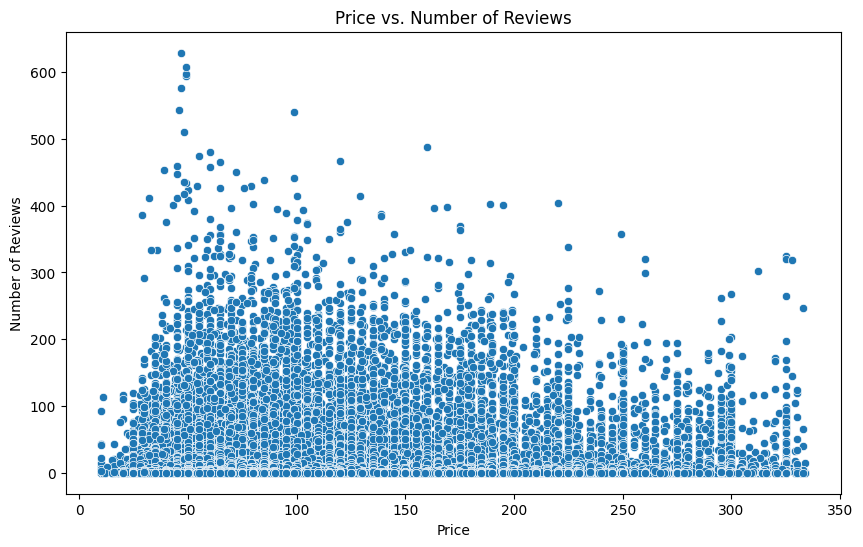

In [ ]:
# Price vs. Number of Reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='price', y='number_of_reviews')
plt.title('Price vs. Number of Reviews')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.show()


2C. Checking the distribution of the target variable and handling skewness

Distribution of Price

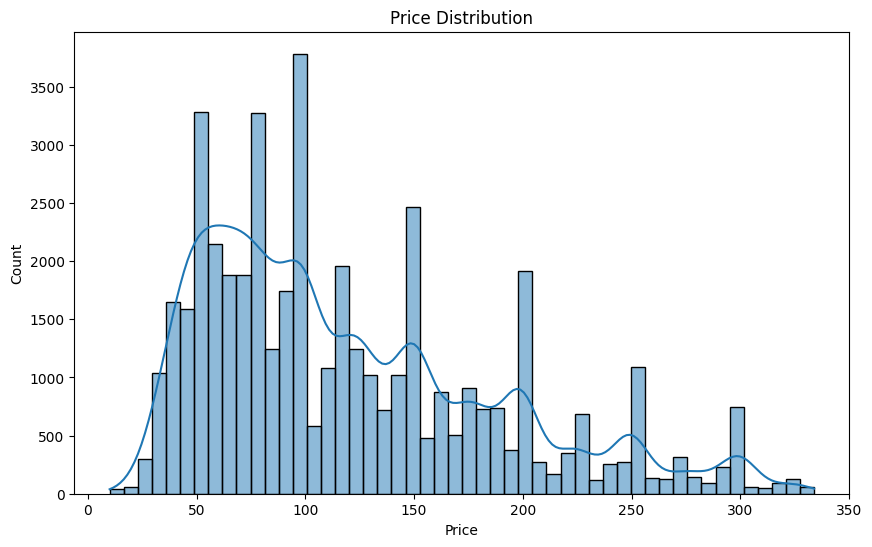

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pandas_df = df.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


Handling Skewness

In [ ]:
from pyspark.sql.functions import col, log1p, expm1
df = df.withColumn('price', log1p(col('price')))

# the inverse transformation
#df = df.withColumn('price_prediction', expm1(col('price_prediction')))

Price Distribution after Handling Skewness

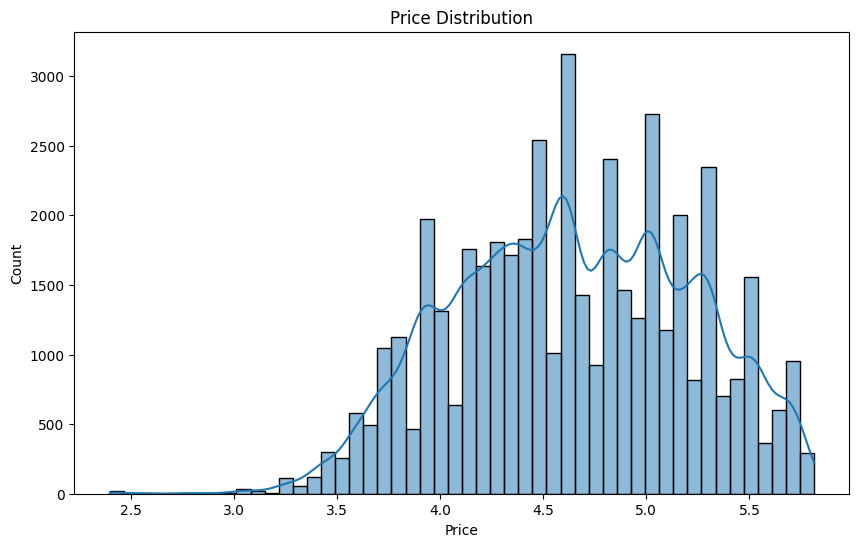

In [ ]:
pandas_df = df.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Converting Price Category column type to Numeric

In [ ]:
indexer = StringIndexer(inputCol='price_category', outputCol='price_category_numeric')
df = indexer.fit(df).transform(df)

mapping_expr = F.create_map(
    F.lit(0), F.lit(1),  # Map index 0 to 1
    F.lit(1), F.lit(2),  # Map index 1 to 2
    F.lit(2), F.lit(3)   # Map index 2 to 3
)

df = df.withColumn('pc_numeric', mapping_expr[F.col('price_category_numeric')])

In [ ]:
print(df.select('pc_numeric').distinct().count())

3


3. Prediction and Modeling

In [ ]:
training_df, testing_df = df.randomSplit([0.7, 0.3], seed = 1890)

3A. Model 1  - Linear regression (Predicting Price)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude',
              'calculated_host_listings_count', 'availability_365',
              'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

linear_regression = LinearRegression(
    featuresCol='scaled_features',
    labelCol='price'
)

pipeline = Pipeline(stages=[feature_assembler, feature_scaler, linear_regression])
model = pipeline.fit(training_df)
predictions = model.transform(testing_df)
evaluator = RegressionEvaluator(
    labelCol='price',
    predictionCol='prediction',
    metricName='mse'
)

mse = evaluator.evaluate(predictions)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
predictions = predictions.withColumn(
    'absolute_percentage_error',
    F.abs((F.col('price') - F.col('prediction')) / F.col('price')) * 100)
mape = predictions.agg(F.mean('absolute_percentage_error')).collect()[0][0]

print(f'Mean Squared Error (MSE) on Testing Data: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Squared Error (MSE) on Testing Data: 0.1359640092300327
Root Mean Squared Error (RMSE): 0.36873297822412454
R-squared (R2): 0.583059211501012
Mean Absolute Percentage Error (MAPE): 6.269089258422593


3A. Model 2 - Logistic regression (Predicting Price Category)

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude', 'calculated_host_listings_count', 'availability_365',
                'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

logistic_regression = LogisticRegression(featuresCol='scaled_features', labelCol='pc_numeric', family='multinomial')

pipeline_classifier = Pipeline(stages=[feature_assembler, feature_scaler, logistic_regression])
model_classifier = pipeline_classifier.fit(training_df)
predictions_classifier = model_classifier.transform(testing_df)

evaluator_classifier = MulticlassClassificationEvaluator(labelCol='pc_numeric', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_classifier.evaluate(predictions_classifier)
print(f'Accuracy on Testing Data: {accuracy}')

Accuracy on Testing Data: 0.6738778513612951


*3B*. Model 1 - Decision Tree (Predicting Price)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude',
              'calculated_host_listings_count', 'availability_365',
              'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)
feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

decision_tree_regressor = DecisionTreeRegressor(featuresCol="scaled_features", labelCol="price")
pipeline = Pipeline(stages=[feature_assembler, feature_scaler, decision_tree_regressor])
param_grid = ParamGridBuilder() \
    .addGrid(decision_tree_regressor.maxDepth, [5, 10, 15]) \
    .addGrid(decision_tree_regressor.maxBins, [32, 64, 128]) \
    .build()
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cross_validator.fit(training_df)
predictions = cv_model.transform(testing_df)

mse = evaluator.evaluate(predictions)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
predictions = predictions.withColumn(
    'absolute_percentage_error',
    F.abs((F.col('price') - F.col('prediction')) / F.col('price')) * 100)
mape = predictions.agg(F.mean('absolute_percentage_error')).collect()[0][0]

print(f"Mean Squared Error (MSE) on Testing Data: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Squared Error (MSE) on Testing Data: 0.13288184661872104
Root Mean Squared Error (RMSE): 0.36452962378758885
R-squared (R2): 0.5925108253267577
Mean Absolute Percentage Error (MAPE): 6.108844202492962


*3B*. Model 2 - Decision Tree Classifier (Predicting Price Category)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude', 'calculated_host_listings_count', 'availability_365',
                'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

decision_tree_classifier = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="pc_numeric")

pipeline = Pipeline(stages=[feature_assembler, feature_scaler, decision_tree_classifier])

param_grid = ParamGridBuilder() \
    .addGrid(decision_tree_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(decision_tree_classifier.maxBins, [32, 64, 128]) \
    .build()

evaluator_classifier = MulticlassClassificationEvaluator(labelCol='pc_numeric', predictionCol='prediction', metricName='accuracy')

cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_classifier,
    numFolds=3
)
cv_model_classifier = cross_validator.fit(training_df)
predictions_classifier = cv_model_classifier.transform(testing_df)

accuracy_classifier = evaluator_classifier.evaluate(predictions_classifier)
print(f'Accuracy on Testing Data: {accuracy_classifier}')


Accuracy on Testing Data: 0.6723325974981604


3C. Model 1 - Random Forest (Predicting Price)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude',
              'calculated_host_listings_count', 'availability_365',
              'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

random_forest = RandomForestRegressor(
    featuresCol='scaled_features',
    labelCol='price'
)

pipeline = Pipeline(stages=[feature_assembler, feature_scaler, random_forest])

param_grid = ParamGridBuilder() \
    .addGrid(RandomForestRegressor.maxDepth, [5, 10, 15]) \
    .addGrid(RandomForestRegressor.numTrees, [50, 100, 200]) \
    .build()

cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mse'),
    numFolds=3
)

model = cross_validator.fit(training_df)
predictions = model.transform(testing_df)
evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mse')

mse = evaluator.evaluate(predictions)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
predictions = predictions.withColumn(
    'absolute_percentage_error',
    F.abs((F.col('price') - F.col('prediction')) / F.col('price')) * 100)
mape = predictions.agg(F.mean('absolute_percentage_error')).collect()[0][0]

print(f'Mean Squared Error (MSE) on Testing Data: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Squared Error (MSE) on Testing Data: 0.13962424807865859
Root Mean Squared Error (RMSE): 0.3736632816837354
R-squared (R2): 0.5718348964761533
Mean Absolute Percentage Error (MAPE): 6.427173076607271


*3C*. Model 2 - Random Forest Classifier (Predicting Price Category)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude', 'calculated_host_listings_count', 'availability_365',
                'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

random_forest_classifier = RandomForestClassifier(featuresCol='scaled_features', labelCol='pc_numeric')

pipeline = Pipeline(stages=[feature_assembler, feature_scaler, random_forest_classifier])

param_grid = ParamGridBuilder() \
    .addGrid(random_forest_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(random_forest_classifier.numTrees, [50, 100, 200]) \
    .build()

evaluator_classifier = MulticlassClassificationEvaluator(labelCol='pc_numeric', predictionCol='prediction', metricName='accuracy')

cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_classifier,
    numFolds=3
)

model_classifier = cross_validator.fit(training_df)
predictions_classifier = model_classifier.transform(testing_df)

accuracy_classifier = evaluator_classifier.evaluate(predictions_classifier)
print(f'Accuracy on Testing Data: {accuracy_classifier}')

Accuracy on Testing Data: 0.6616629874908021


3D. Model 1 - Gradient Boosting Tree (Predicting Price)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

feature_assembler = VectorAssembler(
    inputCols=['longitude', 'latitude',
              'calculated_host_listings_count', 'availability_365',
              'room_type_ohe', 'neighbourhood_ohe', 'neighbourhood_group_ohe'],
    outputCol='features'
)

feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

gbt = GBTRegressor(
    featuresCol='scaled_features',
    labelCol='price',
    maxIter=20,
    maxDepth=5
)

pipeline = Pipeline(stages=[feature_assembler, feature_scaler, gbt])

param_grid = (ParamGridBuilder()
              .addGrid(gbt.maxDepth, [5, 8])
              .addGrid(gbt.maxIter, [20, 30])
              .build())

evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='mse')

cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cross_validator.fit(training_df)
predictions = cv_model.transform(testing_df)

mse = evaluator.evaluate(predictions)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})
predictions = predictions.withColumn(
    'absolute_percentage_error',
    F.abs((F.col('price') - F.col('prediction')) / F.col('price')) * 100)
mape = predictions.agg(F.mean('absolute_percentage_error')).collect()[0][0]

print(f'Mean Squared Error (MSE) on Testing Data: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Squared Error (MSE) on Testing Data: 0.12830315612356047
Root Mean Squared Error (RMSE): 0.35819429940126135
R-squared (R2): 0.6065516206530799
Mean Absolute Percentage Error (MAPE): 6.06601752844981


For k=2, Accuracy: 0.5331125827814569
For k=3, Accuracy: 0.3839587932303164
For k=4, Accuracy: 0.3161147902869757
For k=5, Accuracy: 0.27689477557027226
For k=6, Accuracy: 0.2554083885209713
For k=7, Accuracy: 0.23885209713024283
For k=8, Accuracy: 0.2285504047093451
For k=9, Accuracy: 0.2177336276674025
For k=10, Accuracy: 0.20684326710816778


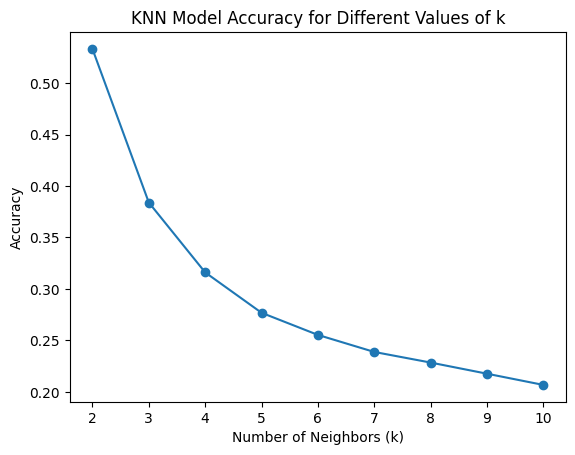

Best k: 2, Best Accuracy: 0.5331125827814569


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

#assemble the features
feature_assembler = VectorAssembler(
    inputCols=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
               'calculated_host_listings_count', 'availability_365', 'room_type_ohe'],
    outputCol='features'
)

#scale
feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

#empty list to store accuracy scores
accuracy_scores = []

#loop over different values of k
for k in range(2, 11):
    #create KNN model
    knn_model = KNeighborsClassifier(n_neighbors=k)

    #build pipeline
    pipeline = Pipeline(stages=[feature_assembler, feature_scaler])

    #fit the pipeline on training data
    model = pipeline.fit(training_df)

    #transform testing data
    transformed_testing_df = model.transform(testing_df)

    #extract features and labels
    features = np.array(transformed_testing_df.select('scaled_features').rdd.map(lambda x: x[0].toArray()).collect())
    prices = np.array(transformed_testing_df.select('price').rdd.map(lambda x: x[0]).collect())

    #train the KNN model
    knn_model.fit(features, prices)

    #make predictions using the model
    predictions = knn_model.predict(features)

    #evaluate model accuracy
    accuracy = accuracy_score(prices, predictions)

    #print results
    print(f"For k={k}, Accuracy: {accuracy}")

    #append accuracy to the list
    accuracy_scores.append(accuracy)

#plot the accuracy scores
plt.plot(range(2, 11), accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different Values of k')
plt.show()

#retrieve the best k and its corresponding accuracy
best_k = accuracy_scores.index(max(accuracy_scores)) + 2
best_accuracy = max(accuracy_scores)
print(f"Best k: {best_k}, Best Accuracy: {best_accuracy}")


In [ ]:
pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.7 MB/s eta 0:00:00


For k=2, Silhouette Score: 0.32125938325708103
For k=3, Silhouette Score: 0.2737634078752688
For k=4, Silhouette Score: 0.2328285409205982
For k=5, Silhouette Score: 0.17933901794485677
For k=6, Silhouette Score: 0.19316772750609726
For k=7, Silhouette Score: 0.17763674526000955
For k=8, Silhouette Score: 0.13199128600006954
For k=9, Silhouette Score: 0.19382638971555574
For k=10, Silhouette Score: 0.16718252731330832


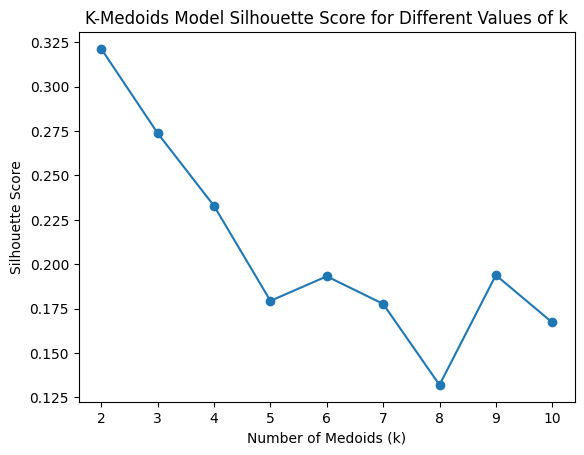

Best k: 2, Best Silhouette Score: 0.32125938325708103


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

#assemble features
feature_assembler = VectorAssembler(
    inputCols=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
               'calculated_host_listings_count', 'availability_365', 'room_type_ohe'],
    outputCol='features'
)

#scaling
feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

#create an empty list to store silhouette scores
silhouette_scores = []

#loop over different values of k (similar process)
for k in range(2, 11):
    #K-Medoids model
    kmedoids_model = KMedoids(n_clusters=k, random_state=42)

    #build pipeline
    pipeline = Pipeline(stages=[feature_assembler, feature_scaler])

    #fit the pipeline on training data
    model = pipeline.fit(training_df)

    #transform testing data
    transformed_testing_df = model.transform(testing_df)

    #extract features
    features = np.array(transformed_testing_df.select('scaled_features').rdd.map(lambda x: x[0].toArray()).collect())

    #fit the K-Medoids model
    kmedoids_model.fit(features)

    #make predictions
    predictions = kmedoids_model.labels_

    #evaluate silhouette score for each K
    silhouette = silhouette_score(features, predictions)

    #print the results
    print(f"For k={k}, Silhouette Score: {silhouette}")

    #append silhouette score to the list
    silhouette_scores.append(silhouette)

#plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Medoids (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Medoids Model Silhouette Score for Different Values of k')
plt.show()

#get the best k and its corresponding silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
best_silhouette_score = max(silhouette_scores)
print(f"Best k: {best_k}, Best Silhouette Score: {best_silhouette_score}")


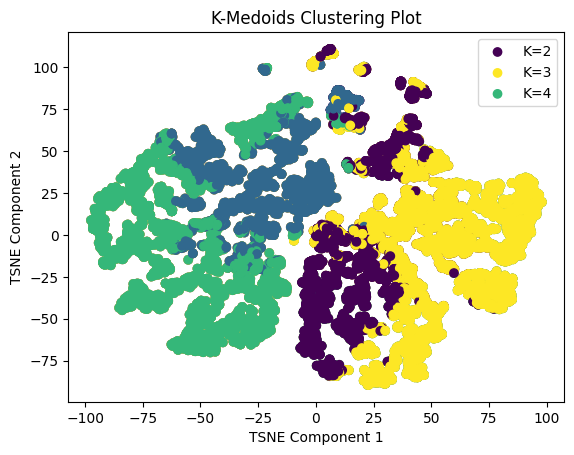

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#assemble features
feature_assembler = VectorAssembler(
    inputCols=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
               'calculated_host_listings_count', 'availability_365', 'room_type_ohe'],
    outputCol='features'
)

#scaling
feature_scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

#create an empty list to store silhouette scores and models
best_k_models = []
silhouette_scores = []

#loop over different values of k
for k in range(2, 11):
    #K-Medoids model
    kmedoids_model = KMedoids(n_clusters=k, random_state=42)

    #build pipeline
    pipeline = Pipeline(stages=[feature_assembler, feature_scaler])

    #fit the pipeline on training data
    model = pipeline.fit(training_df)

    #transform testing data
    transformed_testing_df = model.transform(testing_df)

    #extract features
    features = np.array(transformed_testing_df.select('scaled_features').rdd.map(lambda x: x[0].toArray()).collect())

    #fit K-Medoids model
    kmedoids_model.fit(features)

    #make predictions
    predictions = kmedoids_model.labels_

    #evaluate silhouette score
    silhouette = silhouette_score(features, predictions)

    #store model and silhouette score
    best_k_models.append((k, kmedoids_model))
    silhouette_scores.append(silhouette)

#sort models based on silhouette scores and select the top 3
best_k_models = [model for _, model in sorted(zip(silhouette_scores, best_k_models), reverse=True)[:3]]

#plot the clustering for the top 3 models
for k, kmedoids_model in best_k_models:
    #transform testing data
    transformed_testing_df = model.transform(testing_df)

    #extract features
    features = np.array(transformed_testing_df.select('scaled_features').rdd.map(lambda x: x[0].toArray()).collect())

    #fit K-Medoids model
    kmedoids_model.fit(features)

    #make predictions
    predictions = kmedoids_model.labels_

    #reduce dimensions for visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    #plot all the clusters
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predictions, cmap='viridis', label=f'K={k}')

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('K-Medoids Clustering Plot')
plt.legend()
plt.show()

